In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import nltk
import pickle
import numpy as np

#Preprocessing
from utils1 import pipeline_v1e
# nltk.download('punkt_tab')
from nltk.tokenize import PunktSentenceTokenizer


#Feature extraction
from sklearn.feature_extraction.text import CountVectorizer

#Sentiment Analysis with VADER
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentiment Analysis with TextBlob
# %pip install textblob
from textblob import TextBlob

#Regression Metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# %pip install wordcloud
from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# data with transformer-based sentiment analysis
reviews_sentiment_label = pd.read_csv('reviews_sentiment_label.csv')

In [5]:
reviews_sentiment_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           9954 non-null   object 
 1   Reviewer             9954 non-null   object 
 2   Review               9954 non-null   object 
 3   Rating               9954 non-null   float64
 4   Metadata             9954 non-null   object 
 5   Time                 9954 non-null   object 
 6   Pictures             9954 non-null   int64  
 7   Preprocessed_Review  9952 non-null   object 
 8   Sentiment_Label      9954 non-null   object 
 9   Sentiment_Score      9954 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 777.8+ KB


In [6]:
# labels into numbers - 'negative': 0, 'neutral': 1,'positive': 2
reviews_sentiment_label['Sentiment_Label'] = reviews_sentiment_label['Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [7]:
# to distinguish between Vader sentiment analysis and transformer-based sentiment analysis
reviews_sentiment_label.rename(columns={"Sentiment_Label": "Transformer_Sentiment_Label" , "Sentiment_Score": "Transformer_Sentiment_Score"}, inplace = True)

**VADER**

In [8]:
vader = SentimentIntensityAnalyzer()

In [9]:
#example
print(reviews_sentiment_label['Preprocessed_Review'].iloc[0])
print(vader.polarity_scores(reviews_sentiment_label['Review'].iloc[0]))

The ambience was good, food was quite good. had Saturday lunch, which was cost effective. Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.
{'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'compound': 0.9664}


In [10]:
reviews_compound_list = []
for review in reviews_sentiment_label['Review']:
    review_polarity = vader.polarity_scores(review)
    reviews_compound_list.append(review_polarity["compound"])

In [11]:
reviews_sentiment_label["VADER_Sentiment_Score"] = reviews_compound_list

The standard scoring metric followed by most of the analyzers:
- Positive sentiment: compound score >= 0.05
- Neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- Negative sentiment: compound score <= -0.05

In [12]:
reviews_sentiment_label["VADER_Sentiment_Label"] = list(map(lambda x: "positive" if x >= 0.05 else "negative" if x <= -0.05 else "neutral",  reviews_sentiment_label["VADER_Sentiment_Score"]))

In [13]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Transformer_Sentiment_Label,Transformer_Sentiment_Score,VADER_Sentiment_Score,VADER_Sentiment_Label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,0.9664,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,0.9360,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,0.9186,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,0.8591,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,0.9201,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,2,0.870036,0.9923,positive
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,2,0.983094,0.9579,positive
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0,0.531457,0.9785,positive
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,2,0.982623,0.9359,positive


In [14]:
reviews_sentiment_label['VADER_Sentiment_Label'] = reviews_sentiment_label['VADER_Sentiment_Label'].map({'negative': 0, 'neutral': 1,'positive': 2})

In [15]:
#0 - negative, 1 - neutral, 2 - positive
reviews_sentiment_label['Rating_label'] = reviews_sentiment_label['Rating'].apply(lambda x: 2 if x > 3.5 else 0 if x < 2.5 else 1)

In [16]:
reviews_sentiment_label

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Preprocessed_Review,Transformer_Sentiment_Label,Transformer_Sentiment_Score,VADER_Sentiment_Score,VADER_Sentiment_Label,Rating_label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,"The ambience was good, food was quite good. ha...",2,0.975001,0.9664,2,2
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,Ambience is too good for a pleasant evening. S...,2,0.978647,0.9360,2,2
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,A must try.. great food great ambience. Thnx f...,2,0.988044,0.9186,2,2
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,Soumen das and Arun was a great guy. Only beca...,2,0.972271,0.8591,2,2
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,Food is good. we ordered Kodi drumsticks and b...,2,0.980803,0.9201,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,Madhumathi Mahajan Well to start with nice cou...,2,0.870036,0.9923,2,1
9950,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,This place has never disappointed us.. The foo...,2,0.983094,0.9579,2,2
9951,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,"Bad rating is mainly because of "" Chicken Bone...",0,0.531457,0.9785,2,0
9952,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,I personally love and prefer Chinese Food. Had...,2,0.982623,0.9359,2,2


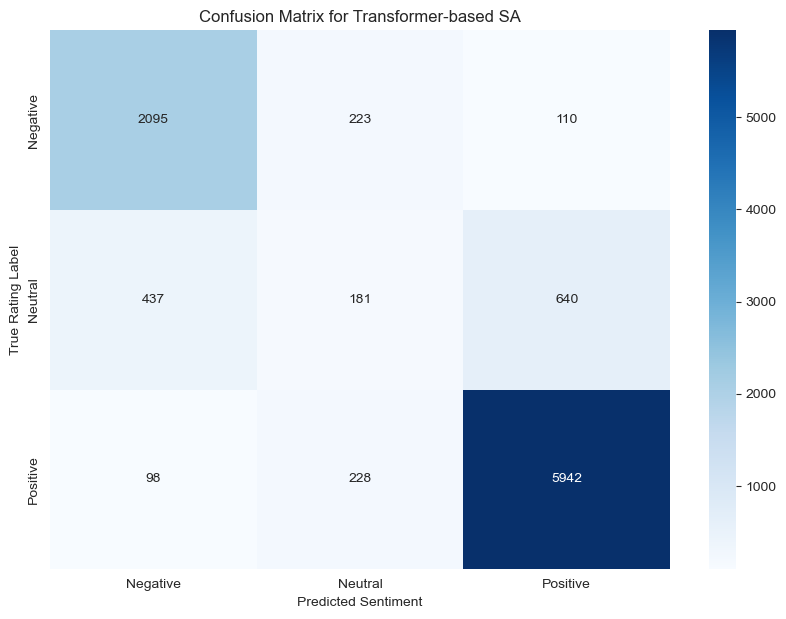

In [14]:
from sklearn.metrics import confusion_matrix

# confusion matrix TRANSFORMER
conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Transformer_Sentiment_Label'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for Transformer-based SA')
# plt.savefig("cf-transformer.jpg", format='jpg')
plt.show()

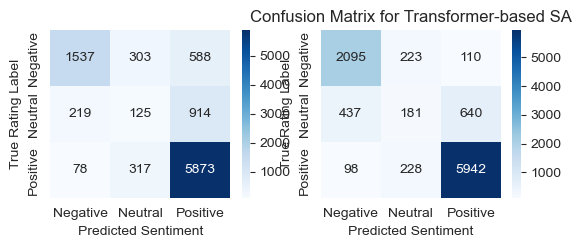

In [24]:
# confusion matrix VADER
conf_matrix2 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['VADER_Sentiment_Label'])
conf_matrix1 = confusion_matrix(reviews_sentiment_label['Rating_label'], reviews_sentiment_label['Transformer_Sentiment_Label'])

sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Rating Label')
plt.title('Confusion Matrix for VADER')
# plt.savefig("cf-vader.jpg", format='jpg')
plt.show()


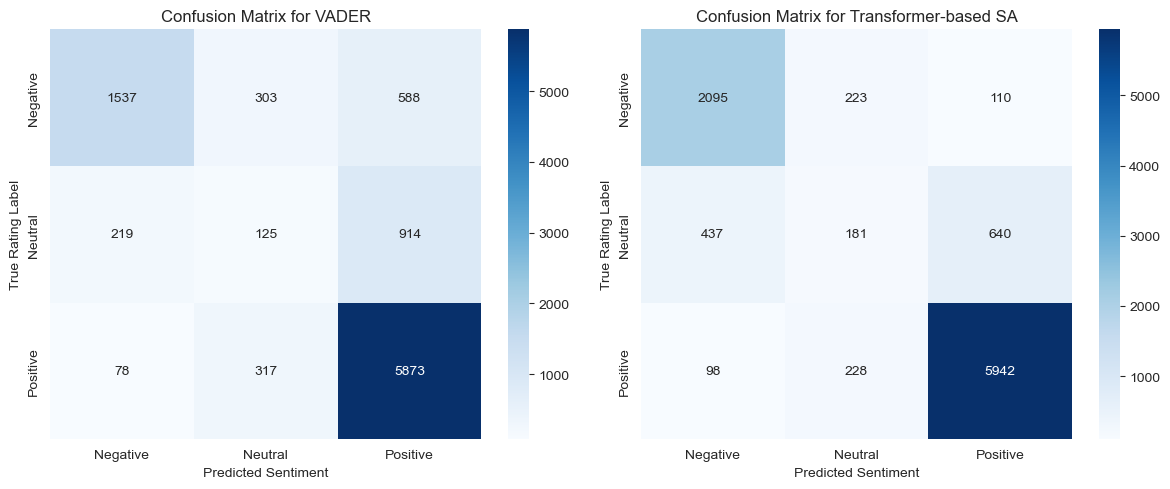

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for side-by-side comparison

# VADER Confusion Matrix
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('True Rating Label')
axes[0].set_title('Confusion Matrix for VADER')

# Transformer-based Confusion Matrix
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('True Rating Label')
axes[1].set_title('Confusion Matrix for Transformer-based SA')

# Adjust layout for readability
plt.tight_layout()
plt.savefig("cf-for-both.jpg")
plt.show()


In [40]:
accuracy_trans = round((conf_matrix1.trace()) / conf_matrix1.sum(), 2)
accuracy_vader = round((conf_matrix2.trace()) / conf_matrix2.sum(), 2)
print("accuracy for transformer:", accuracy_trans)
print("accuracy for vader:", accuracy_vader)

accuracy for transformer: 0.83
accuracy for vader: 0.76


In [29]:
from sklearn.metrics import classification_report

true_labels = reviews_sentiment_label['Rating_label']
predicted_labels_VADER = reviews_sentiment_label['VADER_Sentiment_Label']
predicted_labels_Transf = reviews_sentiment_label['Transformer_Sentiment_Label']

# report converted into dict to save it as csv
report_VADER = classification_report(true_labels, predicted_labels_VADER, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

report_Transf = classification_report(true_labels, predicted_labels_Transf, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)

# DataFrame
df_VADER = pd.DataFrame(report_VADER).transpose()
df_Transf = pd.DataFrame(report_Transf).transpose()

# saving to CSV
df_VADER.to_csv("classification_report_VADER.csv", index=True)
df_Transf.to_csv("classification_report_Transformer.csv", index=True)


In [30]:
df_VADER 

,precision,recall,f1-score,support
Negative,0.838059,0.633031,0.721258,2428.000000
Neutral,0.167785,0.099364,0.124813,1258.000000
Positive,0.796339,0.936981,0.860954,6268.000000
accuracy,0.756982,0.756982,0.756982,0.756982
macro avg,0.600728,0.556459,0.569008,9954.000000
weighted avg,0.727078,0.756982,0.733845,9954.000000


In [18]:
# to zle, powinnno byc vader compound z rating normalized ?

corr_spearman = reviews_sentiment_label[['Rating_label', 'VADER_Sentiment_Label']].corr(method='spearman')
corr_pearson = reviews_sentiment_label[['Rating_label', 'VADER_Sentiment_Label']].corr(method='pearson')

print(f"Spearman correlation: {round(corr_spearman.iloc[0][1],2)}")
print(f"Pearson correlation: {round(corr_pearson.iloc[0][1],2)}")

Spearman correlation: 0.66
Pearson correlation: 0.69
